# Mathe Macht Medikamente: die Simulation
Jitao David Zhang, Rigani Jegatheeswaran, und David Weber

*Mathe Macht Medikamente* ist ein Workshop im Rahmen von Nationen Zukunftstag von Roche am 13.11. Der Workshop ist für Kinder zwischen 5. und 7. Klasse und deren Eltern konzipiert. Mehr Information über den Workshop ist [hier in einer Google Dokument](https://docs.google.com/document/d/1UBZIqVgjBpYKxbMi2KZX1lr_SdCBscWbLFOQXIVed80/edit?usp=sharing) zu finden.

Der Workshop findet zweimal statt: einmal am Morgen und einmal am Nachmittag. Die Daten sind nur für jeweilige Session gespeichert, und danach werden gelöscht.

Für dieses Event planen wir maximum 30 Teams.

## Vorbereitungen

Jedes Kind/Elternteil paar bekommt ein Stück Papier, das ein team-spezifische QR code hat und relevante Informationen enthält.

Beim Scannen der QR Code landet man auf die Webseite für die Event. 

* Tech Check: Team eingeben
* Set 1: Spiel der Körpergrössen
* Set 2: Rat den Umfang
* Set 3: Molekül Memory
* Set 4: Klinische Studie 
* Feedback

Wichtige elemente: 

* Team namen sind alphabetisch sortiert.
* Für alle Abbildungen, die mit 'cursor' dekoriert sind, brauchen wir Interaktivität. Die Teams und deren Eingaben sollen beim Hovering gezeigt werden.
* Jederzeit müssen wir in der Lage sein, alle gesammelten und abgeleiteten Daten (Teams, Vornamen, Körpergrössen, Umhang bzw. Unterschied zum richtigen Wert, usw.) in einer Tabelle zeigen können, um Konzept wie Median zu erklären. Ausser geheim gehalten Daten.

In [1]:
import random
import pandas as pd
import numpy as np
import itables
import matplotlib
import seaborn as sns
import mplcursors as mc

%matplotlib widget

from itables import show
import matplotlib.pyplot as plt

matplotlib_font = {'size': 22}
matplotlib.rc('font', **matplotlib_font)
matplotlib.rcParams['figure.figsize'] = [8, 8]

itables.options.allow_html = True
itables.options.style = "table-layout: auto; width: auto; font-size: huge;"

n_teilnahme = 29
random.seed(1887)
np.random.seed(1887)

umfang_ground_truth = 28

In [2]:
def which_true(bool_list):
    res = [i for i, val in enumerate(bool_list) if val]
    return(res)

    
def groesse_bins(values, bin_size=2):
    min_val = int(np.round(np.min(values)))
    max_val = int(np.round(np.max(values)))
    res = np.arange(min_val-1, max_val+bin_size+1, bin_size) ## +bin_size+1 makes sure that data in the the last bin is shown
    return(res)

def plot_groesse(values, ax, style, bin_size=2):
    value_bins = groesse_bins(values, bin_size=bin_size)
    ax.hist(values, bins=value_bins, width=bin_size, **style)
    ax.set(xticks=value_bins)
    ax.set_xticklabels(ax.get_xticks(), rotation=45)
    ax.plot(values, 0*values, 'd', color="orange", markersize=12)
    return(ax)

In [3]:
## Teams: ChatGPT, https://chatgpt.com/share/e/68f8f919-f328-8009-adbf-f3c76574926e
with open('data/team_namen.txt', 'r') as tn:
    max_team_namen_str = filter(bool, tn.read().split("\n")) ## the filter/book trick removes ANY empty string
    max_team_namen = dict(item.split(":") for item in max_team_namen_str)
## Kindervornamen: https://www.bfs.admin.ch/bfs/de/home/statistiken/bevoelkerung/geburten-todesfaelle/vornamen-neugeborene.assetdetail.540003.html
with open('data/kinder_vornamen.txt', 'r') as kf:
    kinder_vornamen = list(filter(bool, kf.read().splitlines()))
## Elternvornamen: https://www.bfs.admin.ch/bfs/de/home/statistiken/bevoelkerung/geburten-todesfaelle/namen-schweiz.html, Jahrgang 1984
with open('data/eltern_vornamen.txt', 'r') as ef:
    eltern_vornamen = list(filter(bool, ef.read().splitlines()))

In [4]:
if n_teilnahme > len(max_team_namen):
    raise ValueError("Zu viel Teilnehmer")

In [5]:
max_team_namen_de = list(max_team_namen.keys())
max_team_namen_en = list(max_team_namen.values())

Nun bereiten wir die Daten für die simulierte klinische Studien vor, und zwar für die maximale Anzahl von Teilnehmenden.

In [6]:
max_placebo_vor = np.random.randint(5, 11, size=len(max_team_namen))
max_placebo_effekt = np.random.normal(loc=0, scale=1, size=len(max_placebo_vor)).astype(int)
max_placebo_nach = np.clip(max_placebo_vor - max_placebo_effekt, a_min=0, a_max=10)
max_molekul_vor = np.random.randint(5, 11, size=len(max_team_namen))
max_molekul_effekt = np.random.normal(loc=3, scale=1, size=len(max_molekul_vor)).astype(int)
max_molekul_nach = np.clip(max_molekul_vor - max_molekul_effekt, a_min=0, a_max=10)
max_eltern_placebo_team = random.sample(max_team_namen_de,
                                        k=int(len(max_team_namen_de)/2))
max_eltern_molekul_team = set(max_team_namen_de).difference(max_eltern_placebo_team)

geheim_max_behandlung_df = pd.DataFrame({'Team_ro': list(max_eltern_placebo_team) + list(max_eltern_molekul_team),
                                         'Eltern_Behandlung': ['Placebo'] * len(max_eltern_placebo_team) + ['Molekül'] * len(max_eltern_molekul_team),
                                         'Kind_Behandlung': ['Molekül'] * len(max_eltern_placebo_team) + ['Placebo'] * len(max_eltern_molekul_team)})
geheim_max_skala = pd.DataFrame({'Team_ro': max_team_namen_de * 2,
                                'Behandlung': ['Placebo'] * len(max_team_namen_de) + ['Molekül'] * len(max_team_namen_de),
                                'Vor': list(max_placebo_vor) + list(max_molekul_vor),
                                'Nach': list(max_placebo_nach) + list(max_molekul_nach)})
geheim_max_skala['Behandlung']=pd.Categorical(geheim_max_skala['Behandlung'],
                                              categories=['Placebo', 'Molekül'], ordered=True)
geheim_max_skala.sort_values(["Team_ro", "Behandlung"], inplace=True)
## show(geheim_max_skala)

In [7]:
geheim_max_eltern_skala = geheim_max_behandlung_df.merge(geheim_max_skala,
                                                         left_on=['Team_ro', 'Eltern_Behandlung'],
                                                         right_on=['Team_ro', 'Behandlung']).rename(columns={
    'Vor': 'Eltern_Vor',
    'Nach': 'Eltern_Nach'})[['Team_ro', 'Eltern_Behandlung','Kind_Behandlung', 'Eltern_Vor', 'Eltern_Nach']]
geheim_max_kind_skala = geheim_max_behandlung_df.merge(geheim_max_skala,
                                                         left_on=['Team_ro', 'Kind_Behandlung'],
                                                         right_on=['Team_ro', 'Behandlung']).rename(columns={
    'Vor': 'Kind_Vor',
    'Nach': 'Kind_Nach'})[['Team_ro', 'Kind_Vor', 'Kind_Nach']]
geheim_max_eltern_kind_skala = geheim_max_eltern_skala.merge(geheim_max_kind_skala,
                                                 on="Team_ro").sort_values("Team_ro").reset_index()
show(geheim_max_eltern_kind_skala)

Loading ITables v2.5.2 from the internet... (need help?)


## Tech Check: Team und Namen eingeben

Jedes Team (Eltern + Kind) scannt den QR code (jedes Team, i.e. auf jedem Papier, hat ein eigenes QR Code). Der Server fragt nach Vornamen von dem Elternteil und dem Kind.

Ergebnisse:

* Eine Tabelle mit alle Teamnamen, die benutzt werden, und der Vornamen von Kindern und Eltern. Die Tabelle soll spaltenweise sortierbar sein.
* Eine Tabelle mit allen einzigartigen Vornamen, und deren Frequenz untern Eltern, Kindern, und beiden.

In [8]:
team_namen_de = np.sort(random.sample(max_team_namen_de, n_teilnahme))
team_namen_en = [max_team_namen[k] for k in team_namen_de]
team_kind_vornamen = random.choices(kinder_vornamen, k=n_teilnahme) ## choices sample WITH replacement, samples WITHOUT replacement
team_eltern_vornamen = random.choices(eltern_vornamen, k=n_teilnahme)

In [9]:
team_df = pd.DataFrame({'Team_ro':team_namen_de,
                        'Team_indikation': team_namen_en,
                        'Eltern': team_eltern_vornamen,
                        'Kind': team_kind_vornamen})
team_df.set_index("Team_ro");

In [10]:
show(team_df, paging=False)

Loading ITables v2.5.2 from the internet... (need help?)


Beim Tech Check wird erklärt, dass wir viel mit gesammelten Informationen machen können, zum Beispiel welche Vornamen sind mehrmals präsent. 

In [11]:
team_all_namen = team_eltern_vornamen + team_kind_vornamen
team_all_namen_frequenz = pd.Series(team_all_namen).value_counts().reset_index()
team_all_namen_frequenz.columns = ['Name', 'Frequenz']
show(team_all_namen_frequenz)

Loading ITables v2.5.2 from the internet... (need help?)


## Set 1: Körpergrössen

Eingaben:

* Teamname
* Grösse von dem Elternteil, in centimeter (validation: nummer, und centimeter, NICHT meter, i.e. >10)
* Grösse von dem Kind, in centimeter

Folgende Konzepte werden erklärt:

* Histogram
* Boxplot
* Scatterplot (anhand von einem interaktiven Plot)
* Median
* Korrelation

In [12]:
np.random.seed(1887)
eltern_groesse, kind_groesse = np.around(np.random.multivariate_normal(mean=[180, 120], cov=[[15, 7], [7, 15]], size=n_teilnahme).T, 1)

In [13]:
team_df["Eltern_groesse"] = eltern_groesse
team_df["Kind_groesse"] = kind_groesse

[Text(0.5, 0, 'Grösse vom Eltern [centimeter]')]

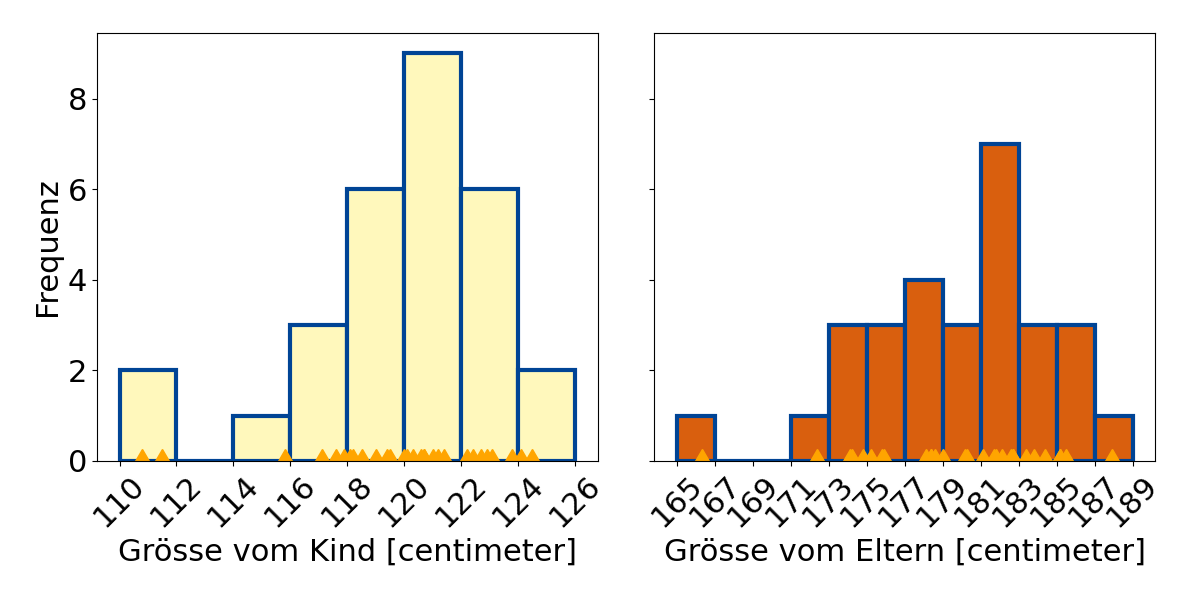

In [14]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, 
                        figsize=(12, 6))


axs[0] = plot_groesse(kind_groesse, axs[0],
                      style={'facecolor': '#FFF8BC', 'edgecolor': '#004495', 'linewidth': 3})
axs[0].set(xlabel="Grösse vom Kind [centimeter]", ylabel="Frequenz")
axs[1] = plot_groesse(eltern_groesse, axs[1],
                      style={'facecolor': '#D95F0E', 'edgecolor': '#004495', 'linewidth': 3})
axs[1].set(xlabel="Grösse vom Eltern [centimeter]")
## plt.close(fig)

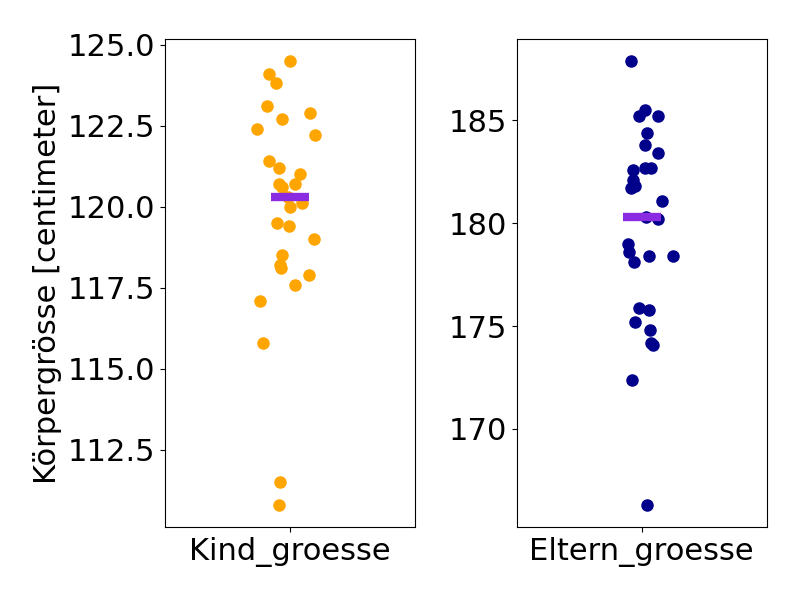

In [15]:
fig, ax_gs = plt.subplots(1, 2, figsize=(8, 6), tight_layout=True)
team_df.boxplot('Kind_groesse', ax=ax_gs[0],
                grid=False, positions=[1],
                showfliers=False,
                boxprops=dict(linewidth=0),
                whiskerprops=dict(linewidth=0),
                medianprops=dict(linewidth=6, color="blueviolet"),
                capprops=dict(linewidth=0))
team_df.boxplot('Eltern_groesse', ax=ax_gs[1],
                grid=False, positions=[1],
                showfliers=False,
                boxprops=dict(linewidth=0),
                whiskerprops=dict(linewidth=0),
                medianprops=dict(linewidth=6, color="blueviolet"),
                capprops=dict(linewidth=0))
ax_gs[0].plot(np.random.normal(1, 0.05, len(team_df)),
        team_df['Kind_groesse'], color="orange", linestyle="none", marker="o", markersize=8, label="Kind")
ax_gs[1].plot(np.random.normal(1, 0.05, len(team_df)),
        team_df['Eltern_groesse'], color="darkblue", linestyle="none", marker="o", markersize=8, label="Eltern")
g0cursor = mc.cursor(ax_gs[0], hover=mc.HoverMode.Transient)
g0cursor.connect("add", lambda sel: sel.annotation.set_text(team_df["Team_ro"][sel.index] + "\n" +
                                                          team_df["Kind"][sel.index] + ": " + str(team_df["Kind_groesse"][sel.index]) + "cm"))
g1cursor = mc.cursor(ax_gs[1], hover=mc.HoverMode.Transient)
g1cursor.connect("add", lambda sel: sel.annotation.set_text(team_df["Team_ro"][sel.index] + "\n" +
                                                          team_df["Eltern"][sel.index] + ": " + str(team_df["Eltern_groesse"][sel.index]) + "cm"))
ax_gs[0].set_ylabel("Körpergrösse [centimeter]")
plt.show()

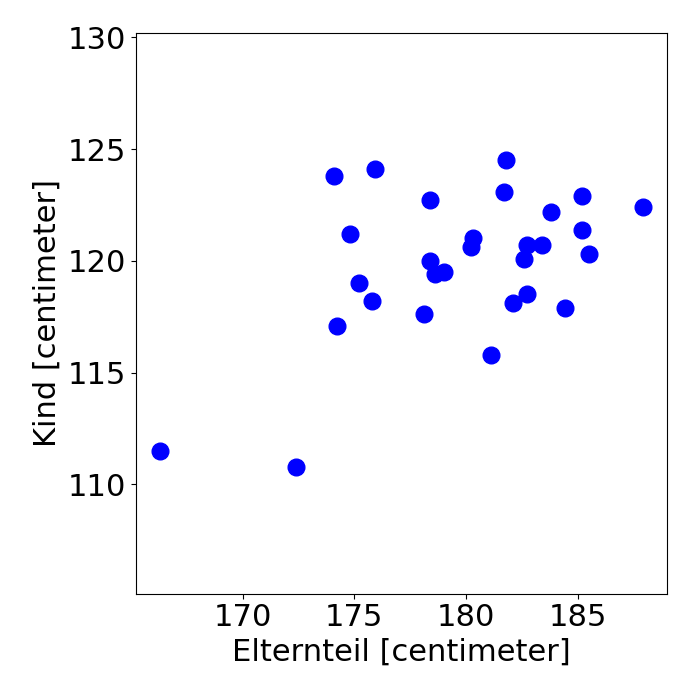

In [16]:
fig, ax_kg = plt.subplots(1, 1, tight_layout=True, figsize=(7, 7))
ax_kg.plot("Eltern_groesse", "Kind_groesse", data=team_df, 
         markersize=12,
         linestyle="none", color="blue", marker="o")
cursor = mc.cursor(ax_kg, hover=mc.HoverMode.Transient)
cursor.connect("add", lambda sel: sel.annotation.set_text(team_df["Team_ro"][sel.index] + "\n" +
                                              team_df["Eltern"][sel.index] + ": " + str(team_df["Eltern_groesse"][sel.index]) + "cm\n" +
                                              team_df["Kind"][sel.index] + ": " + str(team_df["Kind_groesse"][sel.index]) + "cm"))
ax_kg.set_xlabel("Elternteil [centimeter]")
ax_kg.set_ylabel("Kind [centimeter]")
ax_kg.axis('equal')
plt.show()

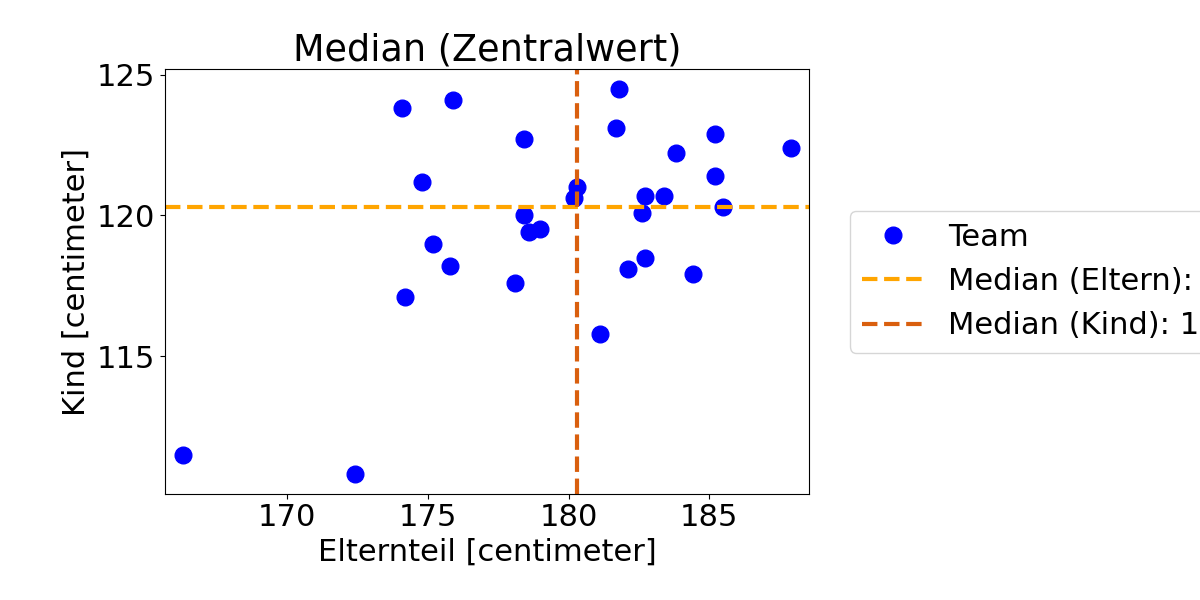

In [17]:
eltern_med = np.median(eltern_groesse)
kind_med = np.median(kind_groesse)
med_dict = {'color': 'darkred',
            'size': 18,
            'weight': 'bold'}

fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(12, 6))
ax.plot("Eltern_groesse", "Kind_groesse", data=team_df, 
         markersize=12, label="Team", 
         linestyle="none", color="blue", marker="o")
ax.set_xlabel("Elternteil [centimeter]")
ax.set_ylabel("Kind [centimeter]")
ax.axis('equal')
ax.axhline(kind_med, c="orange", ls="--", linewidth=3,
           label="Median (Eltern): " + str(eltern_med) + "cm")
ax.axvline(eltern_med, c="#D95F0E", ls="--", linewidth=3,
           label="Median (Kind): " + str(kind_med) + "cm", )
ax.set_title("Median (Zentralwert)")

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
plt.show()
##plt.close(fig)

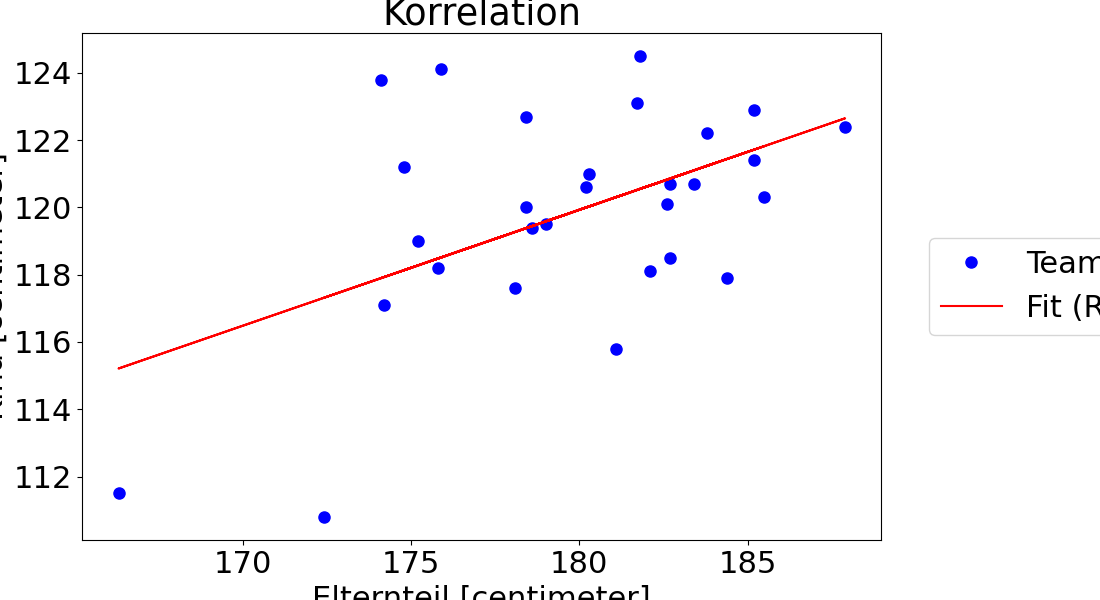

In [18]:
coef, coef_var = np.polyfit(eltern_groesse, kind_groesse, 1, cov=True)
poly1d_fn = np.poly1d(coef)

fig = plt.figure(figsize=(11, 6), tight_layout=True)
ax = plt.subplot(111)
ax.plot("Eltern_groesse", "Kind_groesse", data=team_df, 
         markersize=8, label="Team",
         linestyle="none", color="blue", marker="o")
ax.axis('equal')
ax.set_aspect('equal', 'box')
ax.plot(eltern_groesse, poly1d_fn(eltern_groesse), 'r',
       label="Fit (Regression)")
## ax.plot(eltern_groesse, np.polyval(coef, eltern_groesse), "r")
ax.set_xlabel("Elternteil [centimeter]")
ax.set_ylabel("Kind [centimeter]")
ax.set_title("Korrelation")

# Shrink current axis by 30%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
plt.show()
## plt.close(fig)

## Set 2: Umfang des Raums

Mit einer Markierung auf dem Boden zeigen wir den Eltern und Kindern, wie lang einen Meter ist. Dann haben die Eltern und Kinder 5 Minuten Zeit, dem Unfang des Raums zu schätzen. Dabei dürfen Eltern miteinadner austauschen, und Kinder dürfen miteinander austauschen, aber kein Austasch zwischen Eltern und Kinder sind erlaubt.

Bei der Eingabe geben ein Elternteil und das Kind von jedem Team jeweils einen Schätzungswert. Die top drei Eltern und Kinder, die nähst an den richtigen Wert kommen, gewinnen.

Folgende Konzepte werden erklärt:

* Histogram (Wiederholung)
* Median (Wiederholung)
* Boxplot
* Mangelde Korrelation

In [19]:
np.random.seed(1887)
eltern_umfang_werte = np.around(np.random.normal(umfang_ground_truth * 1.2, scale=5, size=len(team_eltern_vornamen)), 2)
kind_umfang_werte = np.around(np.random.normal(umfang_ground_truth * 0.9, scale=8, size=len(team_kind_vornamen)),1 )
team_df['Eltern_Umfang'] = eltern_umfang_werte
team_df['Kind_Umfang'] = kind_umfang_werte
show(team_df)

Loading ITables v2.5.2 from the internet... (need help?)


In [20]:
all_umfang_werte = [eltern_umfang_werte] + [kind_umfang_werte]
all_umfang_med = np.median(all_umfang_werte)

[Text(0.5, 0, 'Umfang (Eltern) [meter]')]

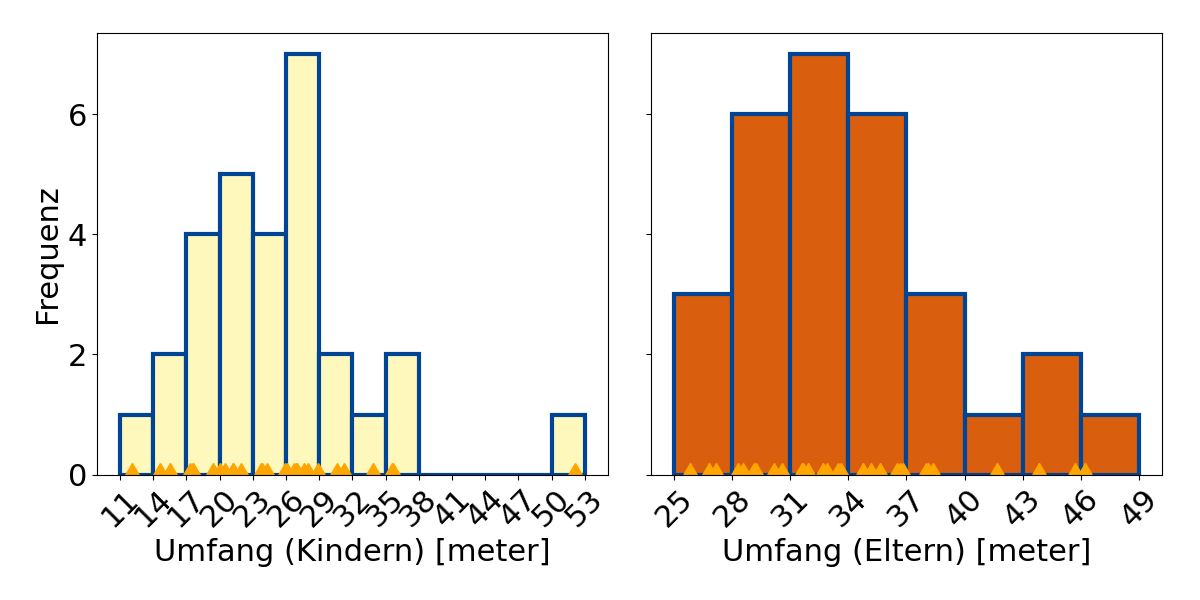

In [21]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, 
                        figsize=(12, 6))

axs[0] = plot_groesse(team_df['Kind_Umfang'], axs[0],
                      style={'facecolor': '#FFF8BC', 'edgecolor': '#004495', 'linewidth': 3},
                     bin_size=3)
axs[0].set(xlabel="Umfang (Kindern) [meter]", ylabel="Frequenz")
axs[1] = plot_groesse(team_df['Eltern_Umfang'], axs[1],
                      style={'facecolor': '#D95F0E', 'edgecolor': '#004495', 'linewidth': 3},
                     bin_size=3)
axs[1].set(xlabel="Umfang (Eltern) [meter]")
## plt.close(fig)

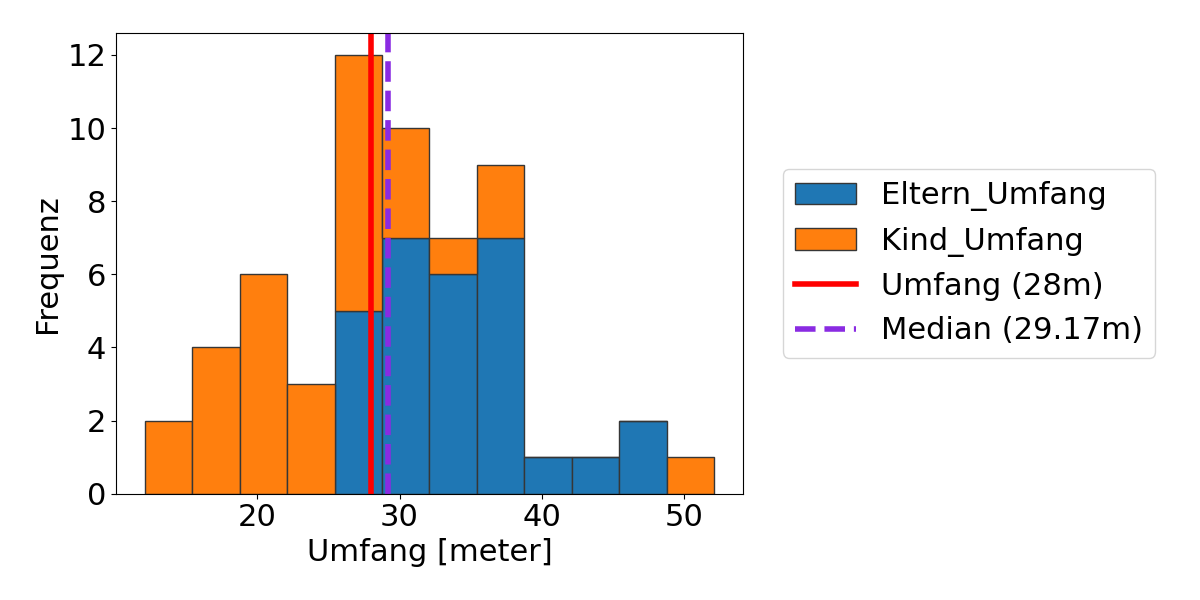

In [22]:
med_dict = {'color': 'darkred',
            'size': 18,
            'weight': 'bold'}
ground_truth_dict = {'color': 'darkgreen',
            'size': 18,
            'weight': 'bold'}

fig, ax = plt.subplots(1, 1, figsize=(12, 6), tight_layout=True)
hist = team_df[['Eltern_Umfang', 'Kind_Umfang']].plot.hist(stacked=True, 
                                                    ec='#363636', ax=ax,
                                                    bins=12)
ugt_line = hist.axvline(umfang_ground_truth, color="red", ls="-", linewidth=4,
                        label="Umfang (" + str(umfang_ground_truth) + "m)")
um_line = hist.axvline(all_umfang_med, color="blueviolet", ls="--", linewidth=4, 
                       label="Median (" + str(all_umfang_med) + "m)")
hist.set_xlabel("Umfang [meter]")
hist.set_ylabel("Frequenz")
hist_handles, hist_labels = hist.get_legend_handles_labels()
hist.legend(handles=hist_handles, 
            labels=hist_labels, bbox_to_anchor=(1.04, 0.5), loc="center left")
plt.show()
## plt.close(fig)

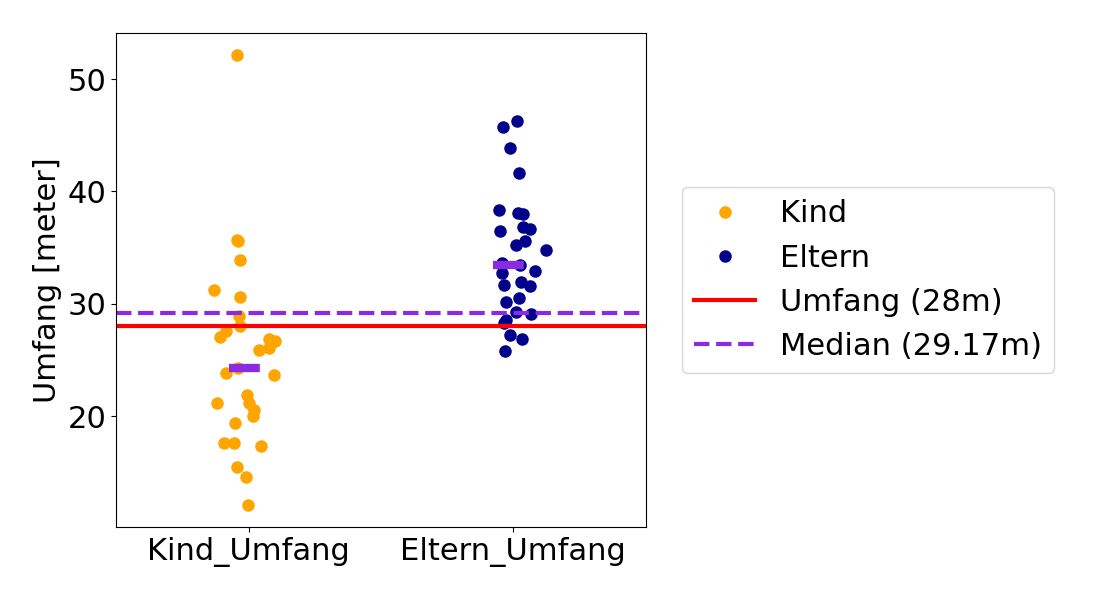

In [23]:
fig, ax_ub = plt.subplots(1, 1, figsize=(11, 6), tight_layout=True)
team_df.boxplot(['Kind_Umfang', 'Eltern_Umfang'], ax=ax_ub,
                grid=False, positions=[1,2],
                showfliers=False,
                boxprops=dict(linewidth=0),
                whiskerprops=dict(linewidth=0),
                medianprops=dict(linewidth=6, color="blueviolet", linestyle="--"),
                capprops=dict(linewidth=0))
ax_ub.plot(np.random.normal(1, 0.05, len(team_df)),
        team_df['Kind_Umfang'], color="orange", linestyle="none", marker="o", markersize=8, label="Kind")
ax_ub.plot(np.random.normal(2, 0.05, len(team_df)),
        team_df['Eltern_Umfang'], color="darkblue", linestyle="none", marker="o", markersize=8, label="Eltern")
bcursor = mc.cursor(ax_ub, hover=mc.HoverMode.Transient)
bcursor.connect("add", lambda sel: sel.annotation.set_text(team_df["Team_ro"][sel.index] + "\n" +
                                                          team_df["Kind"][sel.index] + ": " + str(team_df["Kind_Umfang"][sel.index]) + "m\n" +
                                                          team_df["Eltern"][sel.index] + ": " + str(team_df["Eltern_Umfang"][sel.index]) + "m"))
ugt_line = ax_ub.axhline(umfang_ground_truth, color="red", ls="-", linewidth=3, 
                       label="Umfang (" + str(umfang_ground_truth) + "m)")
um_line = ax_ub.axhline(all_umfang_med, color="blueviolet", ls="--", linewidth=3, 
                    label="Median (" + str(all_umfang_med) + "m)")
ax_ub_handles, ax_ub_labels = ax_ub.get_legend_handles_labels()
ax_ub.set_ylabel("Umfang [meter]")
ax_ub.legend(handles=ax_ub_handles, 
            labels=ax_ub_labels, bbox_to_anchor=(1.04, 0.5), loc="center left")
plt.show()

In [24]:
team_df["Eltern_Umfang_Delta"] = team_df["Eltern_Umfang"] - umfang_ground_truth
team_df["Eltern_Umfang_absDelta"] = abs(team_df["Eltern_Umfang_Delta"])
team_df["Kind_Umfang_Delta"] = team_df["Kind_Umfang"] - umfang_ground_truth
team_df["Kind_Umfang_absDelta"] = abs(team_df["Kind_Umfang_Delta"])

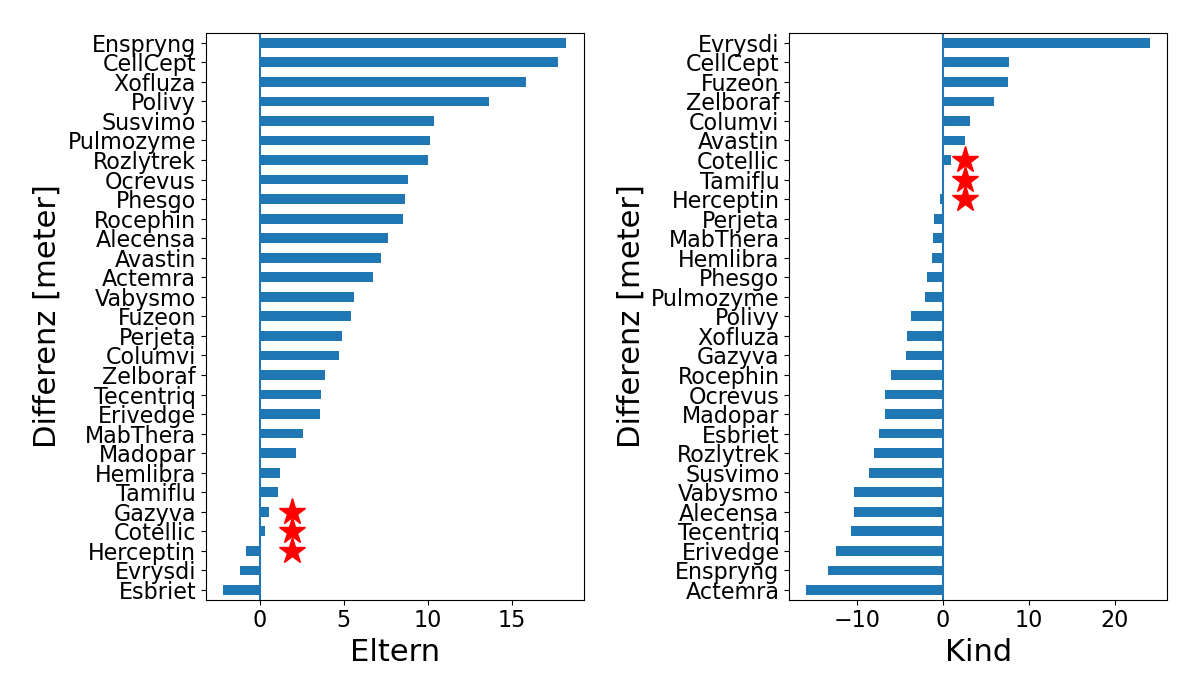

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 7), tight_layout=True)
team_df_eltern_umfang_sorted = team_df.sort_values("Eltern_Umfang_Delta")
team_df_eltern_umfang_sorted.plot.barh(x="Team_ro", y="Eltern_Umfang_Delta",
                                     ax=axes[0], legend=False)
eltern_gewinner = team_df_eltern_umfang_sorted.nsmallest(3, "Eltern_Umfang_absDelta", "all")
eltern_gewinner_bool = team_df_eltern_umfang_sorted["Team_ro"].isin(list(eltern_gewinner["Team_ro"])).tolist()
eltern_gewinner_ind = which_true(eltern_gewinner_bool)
axes[0].plot([axes[0].get_xlim()[1] * 0.1] * len(eltern_gewinner_ind),
        eltern_gewinner_ind, color="red", marker="*", 
        linestyle="none", markersize=20)
axes[0].set_ylabel("Differenz [meter]")
axes[0].set_xlabel("Eltern")
axes[0].axvline(0)

team_df_kind_umfang_sorted = team_df.sort_values("Kind_Umfang_Delta")
team_df_kind_umfang_sorted.plot.barh(x="Team_ro", y="Kind_Umfang_Delta",
                                     ax=axes[1], legend=False)
kind_gewinner = np.argmin(abs(team_df_kind_umfang_sorted["Kind_Umfang_Delta"]))
kind_gewinner = team_df_kind_umfang_sorted.nsmallest(3, "Kind_Umfang_absDelta", "all")
kind_gewinner_bool = team_df_kind_umfang_sorted["Team_ro"].isin(list(kind_gewinner["Team_ro"])).tolist()
kind_gewinner_ind = which_true(kind_gewinner_bool)
axes[1].plot([axes[1].get_xlim()[1] * 0.1] * len(kind_gewinner_ind), 
        kind_gewinner_ind, 
        color="red", marker="*", 
        linestyle="none", markersize=20)
axes[1].set_ylabel("Differenz [meter]")
axes[1].set_xlabel("Kind")
axes[1].axvline(0)

for i in range(len(axes)):
    axes[i].tick_params(axis='both', which='major', labelsize=16)
plt.show()

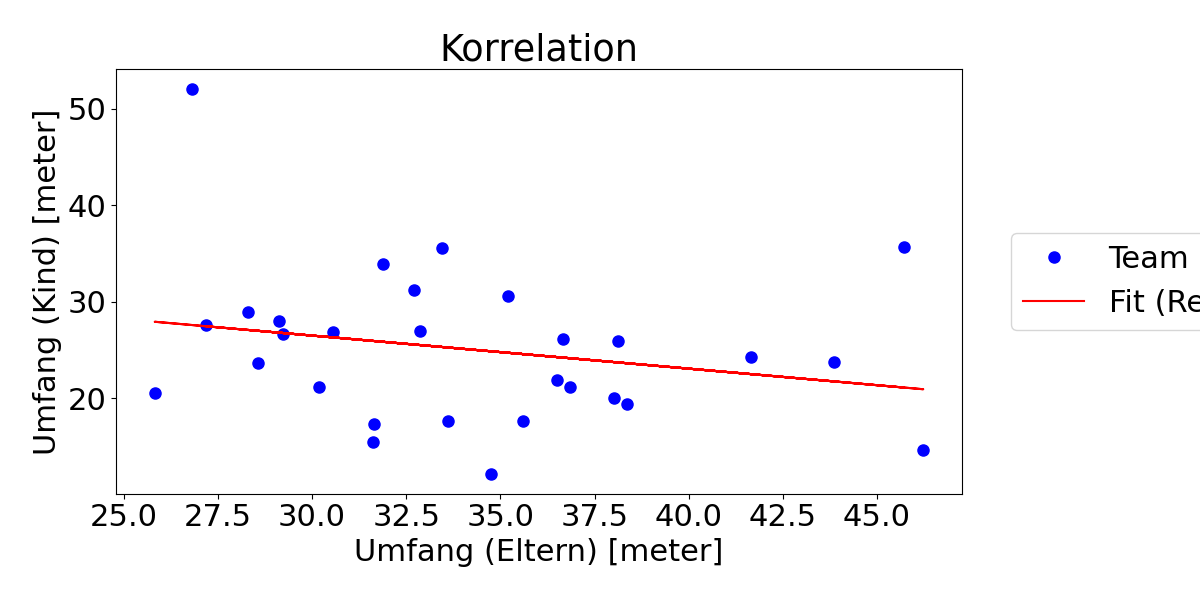

In [26]:
umfang_coef = np.polyfit(team_df['Eltern_Umfang'],
                         team_df['Kind_Umfang'], 1)
umfang_poly1d_fn = np.poly1d(umfang_coef)

fig, ax_uc = plt.subplots(1, 1, figsize=(12, 6), tight_layout=True)
ax_uc.plot("Eltern_Umfang", "Kind_Umfang", data=team_df, 
         markersize=8, label="Team",
         linestyle="none", color="blue", marker="o")
ucursor = mc.cursor(ax_uc, hover=mc.HoverMode.Transient)
ucursor.connect("add", lambda sel: sel.annotation.set_text(team_df["Team_ro"][sel.index] + "\n" +
                                              team_df["Eltern"][sel.index] + ": " + str(team_df["Eltern_Umfang"][sel.index]) + "m\n" +
                                              team_df["Kind"][sel.index] + ": " + str(team_df["Kind_Umfang"][sel.index]) + "m"))
ax_uc.plot(team_df['Eltern_Umfang'],
        umfang_poly1d_fn(team_df['Eltern_Umfang']), 'r',
       label="Fit (Regression)")
ax_uc.set_xlabel("Umfang (Eltern) [meter]")
ax_uc.set_ylabel("Umfang (Kind) [meter]")
ax_uc.set_title("Korrelation")

# Shrink current axis by 20%
box = ax_uc.get_position()
ax_uc.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax_uc.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
plt.show()
##plt.close(fig)

## Set 3: Molecule Memory

Es wird ein Molekül auf dem Bildschirm fün ein paar Sekuneden gezeigt. Dann werden vier Strukturen präsentiert, und die Teams müssen raten, welches Molekül zu den Strukturen passen.

Beispiele sind (vereinfacht)

1. Aspirin
2. Gluthanione
3. Dopamine
4. Baloxavir marboxil
5. Risdiplam

Nach jeder Runde wird ein Barchart gezeigt, das zeigt, welche Teams sich jeweils für A, B, C, D entschieden haben. Am Ende werden gezeigt, wie viele Teams haben 1, 2, 3, 4, bzw. 5mal das Molekül richtig gefunden haben. 

## Set 4: Eine klinische Studie

Jedes Elternteil und ein Kind bekommt ein von zwei Arten Schokokugeln (z.B. Schwarz und Rot). Sowohl die Helfenden als auch die Teams *NICHT* wissen, welche Art ein Medikament ist und welche ein Placebo ist.

Auf dem Papier stehen die Schmerz Skala von Eltern und Kind vor und Nach dem Einnehmen des Schokokulgen. Die Frage ist: ob die Medikament wirkt?

Folgende Konzepte werden erklärt:

* Double blinded experiment
* Placebo/Kontrolle
* Boxplot (Wiederholung)

*WICHITIG* Alle Variablen, die mit 'geheim_' anfang, darf ausser Admin an niemand nicht gezeigt werden. In dem gleichen Sinn dürfen die Spalten 'Eltern_Behandlung' und 'Kind_Behandlung' niemand gezeigt werden.

In [33]:
geheim_behandlung_df = team_df.merge(geheim_max_skala, on="Team_ro").sort_values(['Team_ro', 'Behandlung']).rename(
    columns={'Vor': 'WertVor', 'Nach': 'WertNach'})[['Team_ro', 'Behandlung', 'WertVor', 'WertNach']]
geheim_behandlung_long_df = pd.wide_to_long(geheim_behandlung_df, stubnames='Wert',
                                           i=['Team_ro', 'Behandlung'], j='Typ', suffix="\\w+")
geheim_behandlung_long_df = geheim_behandlung_long_df.reset_index()
pd.melt(geheim_behandlung_long_df, id_vars=['Team_ro', 'Behandlung', 'Typ'], value_vars=['Wert'])
geheim_behandlung_long_df['Typ']=pd.Categorical(geheim_behandlung_long_df['Typ'],
                                              categories=['Vor', 'Nach'], ordered=True)
geheim_behandlung_long_df = geheim_behandlung_long_df.reset_index(drop=True).set_index('Team_ro')
show(geheim_behandlung_long_df)

Loading ITables v2.5.2 from the internet... (need help?)


Die Tabelle unten gibt einen Überblick von allen Daten über die Teams. *Wichtig*: *Eltern_Behandlung* und *Kind_Behandlung* dürfen nicht gezeigt werden.

In [40]:
geheim_behandlung_eltern_kind_df = team_df.merge(geheim_max_eltern_kind_skala, on="Team_ro").drop(['index'], axis=1)
show(geheim_behandlung_eltern_kind_df)

Loading ITables v2.5.2 from the internet... (need help?)


Die folgende Tabelle soll angezeigt werden.

In [29]:
behandlung_eltern_kind_df = geheim_behandlung_eltern_kind_df.drop(['Eltern_Behandlung', 'Kind_Behandlung'], axis=1)
show(behandlung_eltern_kind_df)

Loading ITables v2.5.2 from the internet... (need help?)


In [30]:
geheim_behandlung_long_placebo = geheim_behandlung_long_df.query('Behandlung=="Placebo"')
geheim_behandlung_long_molekul = geheim_behandlung_long_df.query('Behandlung=="Molekül"')
geheim_behandlung_long_placebo_vor = geheim_behandlung_long_placebo.query("Typ == 'Vor'")
geheim_behandlung_long_placebo_nach = geheim_behandlung_long_placebo.query("Typ == 'Nach'")
geheim_behandlung_long_molekul_vor = geheim_behandlung_long_molekul.query("Typ == 'Vor'")
geheim_behandlung_long_molekul_nach = geheim_behandlung_long_molekul.query("Typ == 'Nach'")
pv_x = np.random.normal(1, 0.05, len(geheim_behandlung_long_placebo_vor))
pv_y = geheim_behandlung_long_placebo_vor["Wert"].to_list()
pn_x = np.random.normal(2, 0.05, len(geheim_behandlung_long_placebo_nach))
pn_y = geheim_behandlung_long_placebo_nach["Wert"].to_list()
mv_x = np.random.normal(1, 0.05, len(geheim_behandlung_long_molekul_vor))
mv_y = geheim_behandlung_long_molekul_vor["Wert"].to_list()
mn_x = np.random.normal(2, 0.05, len(geheim_behandlung_long_molekul_nach))
mn_y = geheim_behandlung_long_molekul_nach["Wert"].to_list()

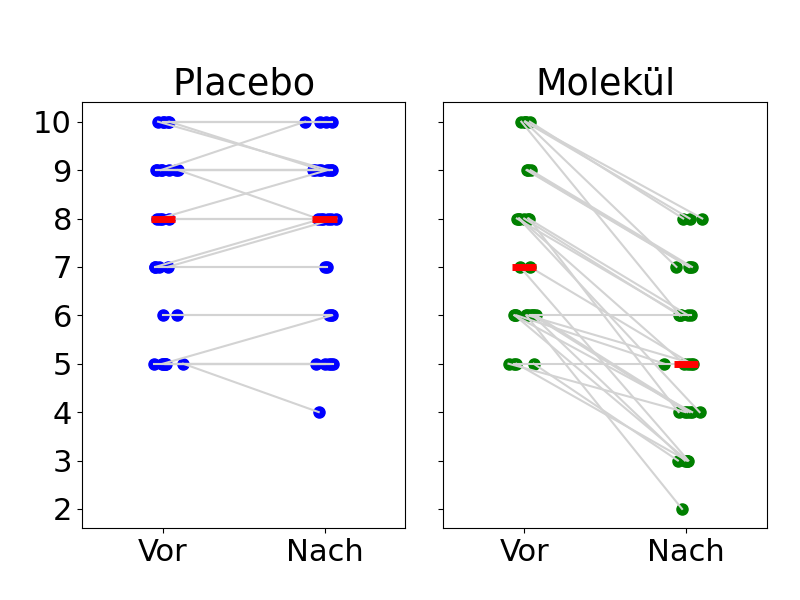

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(8, 6), tight_layout=True, sharey=True)
geheim_behandlung_long_placebo.boxplot("Wert", by="Typ",
                            ax=axes[0], grid=False, positions=[1,2],
                                      boxprops=dict(linewidth=0),
                                      whiskerprops=dict(linewidth=0),
                                       medianprops=dict(linewidth=5, color="red"),
                                      capprops=dict(linewidth=0))
geheim_behandlung_long_molekul.boxplot("Wert", by="Typ",
                            ax=axes[1], grid=False, positions=[1,2],
                                      boxprops=dict(linewidth=0),
                                      whiskerprops=dict(linewidth=0),
                                        medianprops=dict(linewidth=5, color="red"),
                                      capprops=dict(linewidth=0))
axes[0].set_title("Placebo")
axes[0].set_xlabel("")
axes[0].plot(pv_x, pv_y, color="blue", marker="o", markersize=8, linestyle="none")
axes[0].plot(pn_x, pn_y, color="blue", marker="o", markersize=8, linestyle="none")
axes[0].plot([pv_x, pn_x],
             [pv_y, pn_y], color="lightgray")
axes[0].set_yticks(range(0,11))
axes[1].set_title("Molekül")
axes[1].set_xlabel("")
axes[1].plot(mv_x, mv_y, color="green", marker="o", markersize=8, linestyle="none")
axes[1].plot(mn_x, mn_y, color="green", marker="o", markersize=8, linestyle="none")
axes[1].plot([mv_x, mn_x],
             [mv_y, mn_y], color="lightgray")

axes[0].get_figure().suptitle('')
plt.show()